# Syntactic Knowledge Acquisition

## SUBJECT-VERB AGREEMENT

In [28]:
import logging
import pickle
import re
from typing import List

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForMaskedLM


# suppress warnings
logging.getLogger("transformers").setLevel(logging.ERROR)

In [26]:
class SyntacticAbilityEvaluation:

    def __init__(self, model):
        self.model = model
        self.tokenizer = AutoTokenizer.from_pretrained(model)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    def evaluate_corpus(self, data_df, batch_size):
        results_df = pd.DataFrame(columns=['step', 'sent_id', 'masked_sent', 'label', 'correct', 'probability', 'surprisal', 'description'])
        special_tokens = [re.escape(token) for token in self.tokenizer.all_special_tokens if token != self.tokenizer.mask_token]
        pattern = r'\s*(' + '|'.join(special_tokens) + r')\s*'
        sent_id = 0

        for column in data_df.columns:
            for batch in self.generate_batches(data_df[column].tolist(), batch_size):
                masked_inputs, targets = self.prepare_batch(batch)  # shapes: [num_valid_rows, sequence_length], [num_valid_rows, 2]

                masked_sents = self.tokenizer.batch_decode(masked_inputs)
                masked_sents = [re.sub(pattern, ' ', sentence).strip() for sentence in masked_sents]

                correct_labels = self.tokenizer.convert_ids_to_tokens(targets[:, 0])
                incorrect_labels = self.tokenizer.convert_ids_to_tokens(targets[:, 1])

                steps = list(range(0, 200_000, 20_000)) + list(range(200_000, 2_100_000, 100_000))
                for step in steps:
                    checkpoint = self.model + f'-step_{step//1000}k'
                    probs_correct, surprisals_correct, probs_incorrect, surprisals_incorrect = self.evaluate(masked_inputs, targets, checkpoint)
                    
                    results_df = self.update_df(results_df, 
                                                step, 
                                                sent_id + np.arange(len(masked_sents)), 
                                                masked_sents, 
                                                correct_labels,
                                                probs_correct,
                                                surprisals_correct,
                                                truth_value=True,
                                                description=column)
                    
                    results_df = self.update_df(results_df, 
                                                step, 
                                                sent_id + np.arange(len(masked_sents)), 
                                                masked_sents, 
                                                incorrect_labels,
                                                probs_incorrect,
                                                surprisals_incorrect,
                                                truth_value=False,
                                                description=column)
                    
                sent_id += len(masked_sents)
        
        return results_df.sort_values(['step', 'sent_id']).reset_index(drop=True)
    

    def generate_batches(self, data: List, batch_size: int):
        for i in range(0, len(data), batch_size):
            yield data[i:i + batch_size]

    
    def prepare_batch(self, batch):
        """
        INPUT:
            - batch (List[(str, str)]): a list of sentence pairs
        OUTPUT:
            - masked_inputs: tensor of masked input ids - shape: [num_valid_rows, sequence_length]
            - targets: tensor of target ids for the masked positions - shape: [num_valid_rows, 2]
        """
        correct_sents, incorrect_sents = zip(*batch)

        correct_inputs = self.tokenizer(correct_sents, padding=True, return_tensors='pt').input_ids      # shape: [batch_size, sequence_length]
        incorrect_inputs = self.tokenizer(incorrect_sents, padding=True, return_tensors='pt').input_ids  # shape: [batch_size, sequence_length]

        targets_mask = correct_inputs != incorrect_inputs

        # number of differences in each row
        diff_counts = targets_mask.sum(dim=1)   # shape: [batch_size]

        # only keeping rows with exactly one difference 
        # (removes sentence pairs wherein the targets are split into multiple tokens)
        valid_rows = torch.nonzero(diff_counts == 1).squeeze()  # shape: [num_valid_rows (batch_size - num_invalid_rows)]

        target_indices = torch.nonzero(targets_mask[valid_rows])       # shape: [num_valid_rows, 2]
        targets = torch.zeros(len(valid_rows), 2, dtype=torch.long)    # shape: [num_valid_rows, 2]
        targets[:, 0] = correct_inputs[valid_rows, target_indices[:, 1]]
        targets[:, 1] = incorrect_inputs[valid_rows, target_indices[:, 1]]

        # replacing the target token with the mask token in the sentences
        masked_inputs = correct_inputs[valid_rows].to(self.device)       # shape: [num_valid_rows, sequence_length]
        masked_inputs[:, target_indices[:, 1]] = self.tokenizer.mask_token_id

        return masked_inputs, targets
    

    def evaluate(self, masked_input_ids, targets, checkpoint):
        """
        - INPUT: 
            masked_input_ids: tensor of masked input ids - shape: [num_valid_rows, sequence_length]
            targets: tensor of target ids for the masked tokens - shape: [num_valid_rows, 2]
            checkpoint: a pretrained model checkpoint
        - OUTPUT: probability and surprisal of the correct and incorrect targets at the masked positions 
        """
        model = AutoModelForMaskedLM.from_pretrained(checkpoint).to(self.device)
        if torch.cuda.device_count() > 1:
            model = torch.nn.DataParallel(model)

        attention_mask = (masked_input_ids != self.tokenizer.pad_token_id).long()

        model.eval()
        with torch.no_grad():
            logits = model(input_ids=masked_input_ids, attention_mask=attention_mask).logits    # shape: [num_valid_rows, sequence_length, vocab_size]

        probs = F.softmax(logits, dim=-1)

        # probability and surprisal of the targets at the masked positions
        mask_token_indices = torch.nonzero(masked_input_ids == self.tokenizer.mask_token_id, as_tuple=False)
        batch_indices = torch.arange(probs.size(0), device=self.device)
        
        probs_correct = probs[batch_indices, mask_token_indices[:, 1], targets[:, 0]]    # shape: [num_valid_rows]
        surprisals_correct = -torch.log2(probs_correct)                                  # shape: [num_valid_rows]

        probs_incorrect = probs[batch_indices, mask_token_indices[:, 1], targets[:, 1]]  # shape: [num_valid_rows]
        surprisals_incorrect = -torch.log2(probs_incorrect)                              # shape: [num_valid_rows]

        return probs_correct.cpu().tolist(), surprisals_correct.cpu().tolist(), probs_incorrect.cpu().tolist(), surprisals_incorrect.cpu().tolist()
    
    
    def update_df(self, df: pd.DataFrame, 
                        step, 
                        sent_ids: np.array, 
                        masked_sents: List[str], 
                        labels: List[str], 
                        probabilities: List[float], 
                        surprisals: List[float],
                        truth_value=True, 
                        description=''):
        
        label_df = pd.DataFrame(
                    {'step': [step] * len(sent_ids),
                    'sent_id': sent_ids, 
                    'masked_sent': masked_sents, 
                    'label': labels,
                    'correct': [truth_value] * len(sent_ids), 
                    'probability': probabilities, 
                    'surprisal': surprisals,
                    'description': [description] * len(sent_ids)}
                    )        
        return pd.concat([df, label_df], ignore_index=True)

In [48]:
def plot_single_pair(df):
    plt.style.use('ggplot')
    fig, axs = plt.subplots(2, figsize=(8, 8))

    labels = df['label'].unique().tolist()

    for label in labels:
        # plot for surprisals
        df[df['label'] == label].plot(x='step', y='surprisal', title='Surprisal', ax=axs[0], label=label)

        # plot for probabilities
        df[df['label'] == label].plot(x='step', y='probability', title='Probability', ax=axs[1], label=label)

    axs[0].legend()
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In [53]:
def plot_full_corpus(df):
    plt.style.use('ggplot')
    fig, axs = plt.subplots(2, figsize=(9, 7))

    df = df.sort_values('step')
    correct = df[df['correct'] == True]
    incorrect = df[df['correct'] == False]

    # plot for probabilities
    correct.plot(x='step', y='probability', kind='scatter', color='green', alpha=0.2, ax=axs[0], label='individual correct')
    correct.groupby('step').probability.mean().plot(x='step', ylabel='probability', color='green', linestyle='--', ax=axs[0], label='average correct', title='Probability of Correct vs Incorrect Labels')
    incorrect.plot(x='step', y='probability', kind='scatter', color='red', alpha=0.2, ax=axs[0], label='individual incorrect')
    incorrect.groupby('step').probability.mean().plot(x='step', ylabel='probability', color='red', linestyle='--', ax=axs[0], label='average incorrect')

    # plot for surprisals
    correct.plot(x='step', y='surprisal', kind='scatter', color='green', alpha=0.2, ax=axs[1], label='individual correct')
    correct.groupby('step').surprisal.mean().plot(x='step', ylabel='surprisal', color='green', linestyle='--', ax=axs[1], label='average correct', title='Surprisal of Correct vs Incorrect Labels')
    incorrect.plot(x='step', y='surprisal', kind='scatter', color='red', alpha=0.2, ax=axs[1], label='individual incorrect')
    incorrect.groupby('step').surprisal.mean().plot(x='step', ylabel='surprisal', color='red', linestyle='--', ax=axs[1], label='average incorrect')

    axs[0].legend(loc='upper left', bbox_to_anchor=(1.0, 1))
    axs[1].legend(loc='upper left', bbox_to_anchor=(1.0, 1))

    # plt.grid('--')
    plt.tight_layout()
    plt.show()

In [42]:
def plot_proportion_correct(df):
    """ 
    Measures the syntactic ability of the model by comparing the probabilities 
    assigned to the singular and plural variants of the target and plotting 
    the percentage of sentences for which the verb form with the higher 
    probability is the one that respects the agreement rules of the language.
    (Li et al. (2023))
    """
    proportion_df = (df.pivot_table(index=['step', 'sent_id'], columns='correct', values='probability')
                    .reset_index()
                    .rename(columns={False: 'prob_incorrect', True: 'prob_correct'})
                    .assign(correct_higher=lambda x: x['prob_correct'] > x['prob_incorrect'])
                    .groupby('step')['correct_higher']
                    .mean()
                    .reset_index()
                    .rename(columns={'correct_higher': 'proportion'}))

    plt.style.use('ggplot')
    plt.figure(figsize=(8, 4))
    plt.plot(proportion_df['step'], proportion_df['proportion'], marker='o')
    plt.xlabel('Step')
    plt.ylabel('Proportion')
    plt.title('Proportion of Correct Form Having Higher Probability Over Steps')
    # plt.xscale('log')
    plt.show()

In [22]:
def unmask(sentence, checkpoint):
    """ Currently useless """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    model = AutoModelForMaskedLM.from_pretrained(checkpoint).to(device)

    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)

    inputs = tokenizer(sentence, add_special_tokens=False, return_tensors='pt').to(device)
    masked_idx = torch.where(inputs['input_ids'] == tokenizer.mask_token_id)[1]
    
    model.eval()
    with torch.no_grad():
        logits = model(**inputs).logits
    
    probs = F.softmax(logits[0, masked_idx.item(), :], dim=-1)
    top_ids = torch.argsort(probs, axis=-1, descending=True)[:5]
    top_tokens = [tokenizer.convert_ids_to_tokens(id.item()) for id in top_ids]
    top_token_probs = probs[top_ids]

    for token, prob in zip(top_tokens, top_token_probs):
        print(f'Token: {token}, Probability: {prob}')

    return 

---

### Simple Agreement

In [27]:
with open('sample_data/lm_syneval/simple_agrmt.pickle', 'rb') as f:
    simple_agrmt = pd.DataFrame(pickle.load(f))

simple_agrmt

,sing_MS_MV,plur_MS_MV
0,"(the author laughs, the author laugh)","(the authors laugh, the authors laughs)"
1,"(the author swims, the author swim)","(the authors swim, the authors swims)"
2,"(the author smiles, the author smile)","(the authors smile, the authors smiles)"
3,"(the author is tall, the author are tall)","(the authors are tall, the authors is tall)"
4,"(the author is old, the author are old)","(the authors are old, the authors is old)"
...,...,...
65,"(the consultant smiles, the consultant smile)","(the consultants smile, the consultants smiles)"
66,"(the consultant is tall, the consultant are tall)","(the consultants are tall, the consultants is ..."
67,"(the consultant is old, the consultant are old)","(the consultants are old, the consultants is old)"
68,"(the consultant is young, the consultant are y...","(the consultants are young, the consultants is..."


In [45]:
%%time 

SAE = SyntacticAbilityEvaluation('google/multiberts-seed_0')
simple_agrmt_results = SAE.evaluate_corpus(simple_agrmt, 128)
simple_agrmt_results.to_csv('results/simple_agrmt_results.csv', sep='\t', index=False)

/tmp/ipykernel_1040323/484667910.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df, label_df], ignore_index=True)


CPU times: user 1min 43s, sys: 24.1 s, total: 2min 7s
Wall time: 44.9 s


#### Results Analysis

In [46]:
simple_agrmt_results = pd.read_csv('results/simple_agrmt_results.csv', sep='\t')
simple_agrmt_results

,step,sent_id,masked_sent,label,correct,probability,surprisal,description
0,0,0,the author [MASK],laughs,True,0.000010,16.541725,sing_MS_MV
1,0,0,the author [MASK],laugh,False,0.000055,14.157118,sing_MS_MV
2,0,1,the author [MASK],smiles,True,0.000031,14.991373,sing_MS_MV
3,0,1,the author [MASK],smile,False,0.000035,14.821078,sing_MS_MV
4,0,2,the author [MASK] tall,is,True,0.000020,15.581101,sing_MS_MV
...,...,...,...,...,...,...,...,...
6955,2000000,117,the consultants [MASK] old,is,False,0.002472,8.660131,plur_MS_MV
6956,2000000,118,the consultants [MASK] young,are,True,0.144986,2.786019,plur_MS_MV
6957,2000000,118,the consultants [MASK] young,is,False,0.002094,8.899589,plur_MS_MV
6958,2000000,119,the consultants [MASK] short,are,True,0.056748,4.139276,plur_MS_MV


['the customers [MASK]']


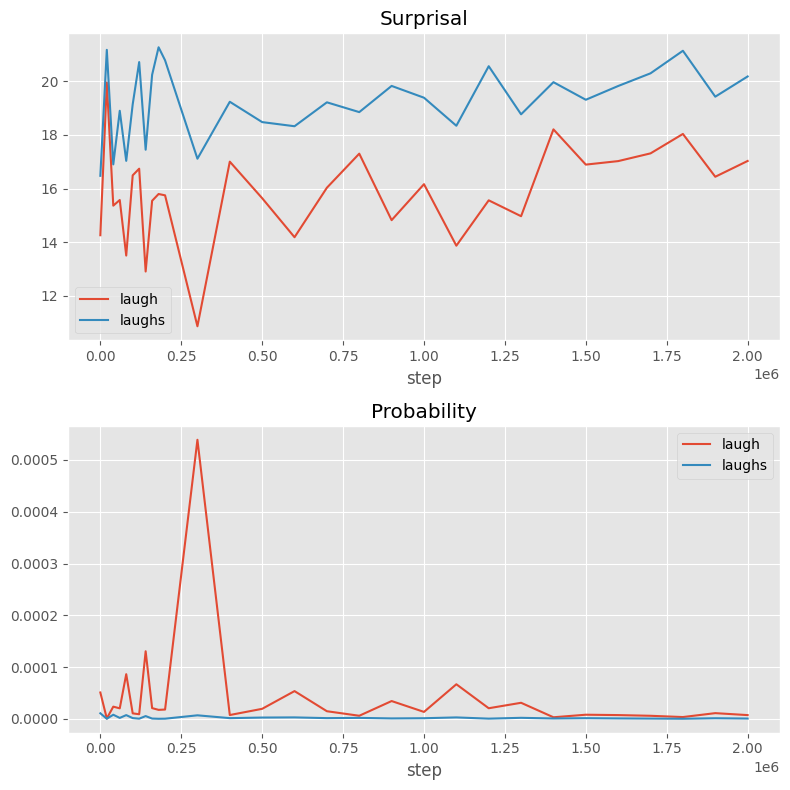

In [49]:
print(simple_agrmt_results[simple_agrmt_results['sent_id'] == 90]['masked_sent'].unique())
plot_single_pair(simple_agrmt_results[simple_agrmt_results['sent_id'] == 90])

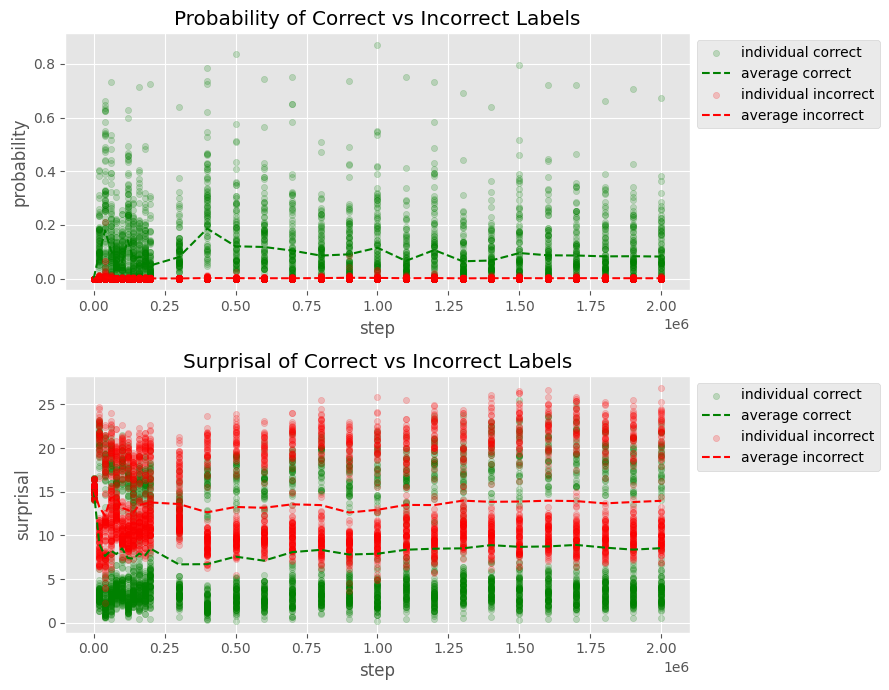

In [54]:
plot_full_corpus(simple_agrmt_results)

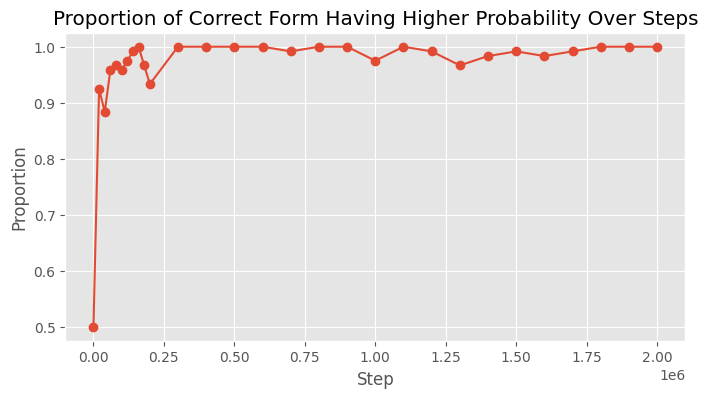

In [55]:
plot_proportion_correct(simple_agrmt_results)

In [56]:
import random

sentence = random.choice(simple_agrmt_results['masked_sent'])
print(sentence)

unmask(sentence, 'google/multiberts-seed_0-step_2000k')

the consultants [MASK] old
Token: :, Probability: 0.054554227739572525
Token: in, Probability: 0.039493709802627563
Token: the, Probability: 0.029140654951334
Token: at, Probability: 0.027842868119478226
Token: ,, Probability: 0.023390144109725952


---

### In a sentential complement

In [35]:
with open('sample_data/lm_syneval/sent_comp.pickle', 'rb') as f:
    sent_comp = pd.DataFrame(pickle.load(f))

sent_comp

,sing_MS_MV_sing_BS,sing_MS_MV_plur_BS,plur_MS_MV_sing_BS,plur_MS_MV_plur_BS
0,"(the mechanic said the author laughs, the mech...","(the mechanics said the author laughs, the mec...","(the mechanic said the authors laugh, the mech...","(the mechanics said the authors laugh, the mec..."
1,"(the mechanic said the author swims, the mecha...","(the mechanics said the author swims, the mech...","(the mechanic said the authors swim, the mecha...","(the mechanics said the authors swim, the mech..."
2,"(the mechanic said the author smiles, the mech...","(the mechanics said the author smiles, the mec...","(the mechanic said the authors smile, the mech...","(the mechanics said the authors smile, the mec..."
3,"(the mechanic said the author is tall, the mec...","(the mechanics said the author is tall, the me...","(the mechanic said the authors are tall, the m...","(the mechanics said the authors are tall, the ..."
4,"(the mechanic said the author is old, the mech...","(the mechanics said the author is old, the mec...","(the mechanic said the authors are old, the me...","(the mechanics said the authors are old, the m..."
...,...,...,...,...
415,"(the banker knew the consultant smiles, the ba...","(the bankers knew the consultant smiles, the b...","(the banker knew the consultants smile, the ba...","(the bankers knew the consultants smile, the b..."
416,"(the banker knew the consultant is tall, the b...","(the bankers knew the consultant is tall, the ...","(the banker knew the consultants are tall, the...","(the bankers knew the consultants are tall, th..."
417,"(the banker knew the consultant is old, the ba...","(the bankers knew the consultant is old, the b...","(the banker knew the consultants are old, the ...","(the bankers knew the consultants are old, the..."
418,"(the banker knew the consultant is young, the ...","(the bankers knew the consultant is young, the...","(the banker knew the consultants are young, th...","(the bankers knew the consultants are young, t..."


In [38]:
%%time 

SAE = SyntacticAbilityEvaluation('google/multiberts-seed_0')
sent_comp_results = SAE.evaluate_corpus(sent_comp, 128)
sent_comp_results.to_csv('results/sent_comp_results.csv', sep='\t', index=False)

/tmp/ipykernel_1040323/484667910.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df, label_df], ignore_index=True)


CPU times: user 13min 48s, sys: 3min 10s, total: 16min 58s
Wall time: 6min 6s


#### Results Analysis

In [57]:
sent_comp_results = pd.read_csv('results/sent_comp_results.csv', sep='\t')
sent_comp_results

,step,sent_id,masked_sent,label,correct,probability,surprisal,description
0,0,0,the mechanic said the author [MASK],laughs,True,0.000020,15.638446,sing_MS_MV_sing_BS
1,0,0,the mechanic said the author [MASK],laugh,False,0.000061,14.008612,sing_MS_MV_sing_BS
2,0,1,the mechanic said the author [MASK],smiles,True,0.000025,15.298842,sing_MS_MV_sing_BS
3,0,1,the mechanic said the author [MASK],smile,False,0.000018,15.729861,sing_MS_MV_sing_BS
4,0,2,the mechanic said the author [MASK] tall,is,True,0.000026,15.239981,sing_MS_MV_sing_BS
...,...,...,...,...,...,...,...,...
83515,2000000,1437,the bankers knew the consultants [MASK] old,is,False,0.000278,11.813169,plur_MS_MV_plur_BS
83516,2000000,1438,the bankers knew the consultants [MASK] young,are,True,0.005562,7.490065,plur_MS_MV_plur_BS
83517,2000000,1438,the bankers knew the consultants [MASK] young,is,False,0.000298,11.711288,plur_MS_MV_plur_BS
83518,2000000,1439,the bankers knew the consultants [MASK] short,are,True,0.001853,9.075992,plur_MS_MV_plur_BS


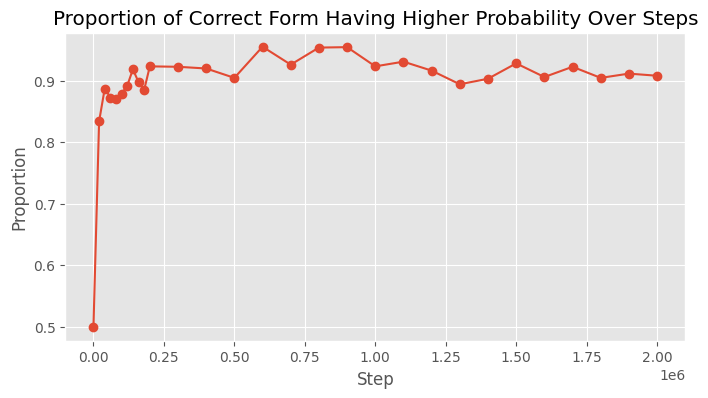

In [58]:
plot_proportion_correct(sent_comp_results)